In [545]:
import pandas as pd
import ndlib
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt


#from .context import bpepi
from fg import FactorGraph
from st import SparseTensor

import sys
# insert at 1, 0 is the script path (or '' in REPL)
#sys.path.append( './bpepi/')

# Generate Epidemics

In [549]:
import networkx as nx
N = 1000
d = 4
seed = 0 # setting seed everywhere for reproducibility TBD
T = 13 # generate contact from 0 to T-1
lamb = 0.3
percentage_infected = 0.03
n_sim = 1
perc_obs = 0

In [550]:
import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc

def generate_one_conf(g, lamb=0.05, T=10, percentage_infected=0.01):
    model = ep.SIModel(g)
    cfg = mc.Configuration()
    cfg.add_model_parameter('beta', lamb) # infection rate
    #cfg.add_model_parameter('gamma', 0.0) # recovery rate
    cfg.add_model_parameter("percentage_infected", percentage_infected)
    model.set_initial_status(cfg)
    iterations = model.iteration_bunch(T, node_status=True)
    status_nodes = np.zeros((T,N))
    for t in range(0,T):
        for node_i in iterations[t]["status"].keys():
            status_nodes[t:T, node_i] = iterations[t]["status"][node_i]
    return np.array(status_nodes)
    
def generate_contacts(G, t_limit, lambda_, p_edge=1, seed=1):
    contacts = []
    random.seed(seed)
    for t in range(t_limit):
        for e in G.edges():
            if random.random() <= p_edge:
                contacts.append((e[0], e[1], t, lambda_))
                contacts.append((e[1], e[0], t, lambda_))
    #contacts = np.array(contacts, dtype=[("t","f8"), ("i","f8"), ("j","f8"), ("lam", "f8")])
    #contacts.sort(axis=0, order=("tù","i","j"))
    return contacts

def generate_obs(conf, frac_obs=0.):
    """[summary]

    Args:
        conf ([type]): [description]
        frac_obs (float, optional): [description]. Defaults to 0.1.

    Returns:
        [type]: [description]
    """
    n_obs = []
    obs_sim = []
    t_obs_sim = []
    N = conf.shape[1]
    T = conf.shape[0]
    for i in range(N):
        if np.random.random() < frac_obs: 
            t_inf = np.nonzero(conf[:, i] == 1)[0]
            if len(t_inf) == 0:
                obs_temp = (i, 0, T-1)
                obs_sim.append(obs_temp)
            else:
                obs_temp = (i, 1, t_inf[0])
                obs_sim.append((obs_temp))
                if t_inf[0] > 0:
                    obs_temp = (i, 0, t_inf[0] - 1)
                    obs_sim.append((obs_temp))
    obs_sim = sorted(obs_sim, key=lambda tup: tup[2])
    return obs_sim

In [551]:
g = nx.random_regular_graph(n=N, d=d)
status_nodes = generate_one_conf(g, lamb=lamb, T = T+1, percentage_infected=percentage_infected)
contacts = generate_contacts(g, T, lambda_=lamb, seed=seed)
list_obs = generate_obs(status_nodes, frac_obs=perc_obs)              
list_obs_all = generate_obs(status_nodes, frac_obs=1)

In [552]:
len(status_nodes)

14

## Generate the factor Graph

Parameters of the SIR model used for inference

In [553]:
pseed = percentage_infected #probability to have sources

### Dummy observations for computing marginals
We want to computer the marginal probabilities of each node to be S, I or R at time t=0 and t=3.

We add dummy observations to the observations list.

We force each node the have these times in the factor graph.

#### factor graph

In [554]:
#f_rnd = FactorGraph(
#    N=N,
#    T=T,
#    contacts=contacts,
#    obs=[],
#    delta=pseed
#)
f = FactorGraph(
    N=N,
    T=T,
    contacts=contacts,
    obs=list_obs,
    delta=pseed
)
#f_inf = FactorGraph(
#    N=N,
#    T=T,
#    contacts=contacts,
#    obs=list_obs_all,
#    delta=pseed
#)

#sim_and_fill(f_rnd, data_obs, data_obs_it, list_obs, ti_list_obs, n_iter, tol, print_it, status_nodes, T, "rnd", M, S, iter_space, sim, flag_sources, flag_obs)
#sim_and_fill(f_informed, data_obs, data_obs_it, list_obs, ti_list_obs, n_iter, tol, print_it, status_nodes, T, "inf", M, S, iter_space, sim, flag_sources, flag_obs)
#print(
#    f"\r S: {i_S+1}/{len(sources_table)} - M: {i_M+1}/{len(obs_table)} - sim: {sim+1}/{n_sim} - time = {time.time()-t2:.2f} s - total time = {time.time()-t1:.0f} s"
#)
#t2 = time.time()

In [555]:
sum(status_nodes[13])

1000.0

# Iterate the BP equations

In [556]:
for _ in range(25):
    f.iterate()
f.iterate()

3.469446951953614e-17

In [557]:
f.loglikelihood()

8.840288501232862e-10

In [479]:
for _ in range(5): f.pop_dyn_RRG(c=d)
f.pop_dyn_RRG(c=d)

4.466912950640278e-17

In [482]:
1/15

0.06666666666666667

In [454]:
status_nodes[:,53]

array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [558]:
sum(f.messages.values[0][-1])

0.0008400800167564374

In [467]:
#pop_dyn_mess= f.messages.values[0]
pop_dyn_mess[-1]

array([8.00777301e-06, 1.14396757e-05, 1.63423939e-05, 2.33462770e-05,
       3.33518243e-05, 4.76454633e-05, 6.80649475e-05, 9.72356393e-05,
       1.38908056e-04, 1.98440080e-04, 2.83485829e-04, 4.04979756e-04,
       5.78542508e-04, 5.78542508e-04])

In [493]:
(1-percentage_infected)/(T+2)*(1-0.7*eta1)

0.020611233199400003

In [560]:
f.messages.values[0][1]

array([0.02061123, 0.00173033, 0.00173033, 0.00173033, 0.00173033,
       0.00173033, 0.00173033, 0.00173033, 0.00173033, 0.00173033,
       0.00173033, 0.00173033, 0.00173033, 0.00173033, 0.00173033])

In [501]:
np.array([0,0,0,0]).shape

(4,)

In [499]:
marg.shape

(15,)

In [498]:
f.messages.values[0]*np.transpose(f.messages.values[1])

array([[4.00000000e-06, 4.12224664e-05, 2.90261872e-05, 2.04288708e-05,
        1.43032995e-05, 9.85356258e-06, 6.54024930e-06, 4.04566406e-06,
        2.23520304e-06, 1.05905253e-06, 4.20856121e-07, 1.41400364e-07,
        4.15736258e-08, 1.11714710e-08, 3.77637193e-09],
       [4.12224664e-05, 2.99405278e-06, 3.58749813e-05, 2.52491087e-05,
        1.76781951e-05, 1.21785328e-05, 8.08343580e-06, 5.00024758e-06,
        2.76260422e-06, 1.30893835e-06, 5.20158068e-07, 1.74764097e-07,
        5.13830160e-08, 1.38074047e-08, 4.66741537e-09],
       [2.90261872e-05, 3.58749813e-05, 7.00049064e-06, 5.51546998e-05,
        3.86166321e-05, 2.66030508e-05, 1.76576322e-05, 1.09226491e-05,
        6.03469248e-06, 2.85927327e-06, 1.13624455e-06, 3.81758478e-07,
        1.12242173e-07, 3.01611938e-08, 1.01956032e-08],
       [2.04288708e-05, 2.52491087e-05, 5.51546998e-05, 1.55308016e-05,
        8.21691986e-05, 5.66064734e-05, 3.75722430e-05, 2.32414189e-05,
        1.28407325e-05, 6.08401562e-0

In [561]:
marg = np.sum(f.messages.values[0]*np.transpose(f.messages.values[1]), axis=0)*(T+2)*(T+2)

In [562]:
sum(status_nodes[12])

1000.0

In [563]:
0.05*50

2.5

In [564]:
sum(marg)

0.9999999999999997

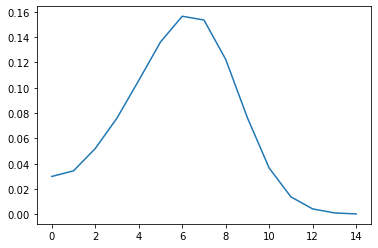

In [565]:
plt.plot(marg)
#plt.plot(range(0,10),2.5**(np.range(0,10)))

In [66]:
r_flag=1
T=f.time
N=f.size
i_tab = range(N)
d_tab =f.messages.degree
old_msgs = SparseTensor(Tensor_to_copy=f.messages, Which=1)
if(all(x == d_tab[0] for x in d_tab)):  
    r_flag=0
    j_tab = range(d_tab[0])
r_flag=1
#old_values = f.messages.values
#np.random.shuffle(order_nodes) #shuffle order in which nodes are updated.
for i in i_tab:
    inc_indices, out_indices = old_msgs.get_all_indices(i) #inc_indices, out_indices = f.messages.get_all_indices(i) 
    inc_msgs = old_msgs.get_neigh_i(i) #inc_msgs = f.messages.get_neigh_i(i)
    inc_lambda0 = f.Lambda0.get_neigh_i(i)
    inc_lambda1 = f.Lambda1.get_neigh_i(i)
    %timeit if (r_flag): j_tab = range(len(out_indices)) #shuffle order in which outoing messages are updated for each node.
    #np.random.shuffle(order_edges)
    for j in j_tab: 
        idx = out_indices[j]
        inc_msgs_j = np.delete(inc_msgs, j, axis=0)
        inc_lambda0_j = np.delete(inc_lambda0, j, axis=0)
        inc_lambda1_j = np.delete(inc_lambda1, j, axis=0)
        gamma0_ki_j = np.reshape(np.prod(np.sum(inc_lambda0_j*inc_msgs_j,axis=1),axis=0),(1,T+2))
        gamma1_ki_j = np.reshape(np.prod(np.sum(inc_lambda1_j*inc_msgs_j,axis=1),axis=0),(1,T+2))
        f.messages.values[idx] = np.transpose(((1-f.delta)*np.reshape(f.observations[i],(1,T+2))*(inc_lambda1[j]*gamma1_ki_j - inc_lambda0[j]*gamma0_ki_j)))
        f.messages.values[idx][0] = f.delta*f.observations[i][0]*np.prod(np.sum(inc_msgs_j[:,:,0],axis=1),axis=0)
        f.messages.values[idx][T+1] = np.transpose((1-f.delta)*f.observations[i][T+1]*inc_lambda1[j][:,T+1]*gamma1_ki_j[0][T+1])
        norm = f.messages.values[idx].sum() #normalize the messages
        f.messages.values[idx] = f.messages.values[idx]/norm

difference = np.abs(old_msgs.values - f.messages.values).max()

173 ns ± 0.502 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


KeyboardInterrupt: 

In [40]:
%timeit f.iterate()

23.3 ms ± 1.57 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [41]:
f.iterate()

3.7414515929867775e-14

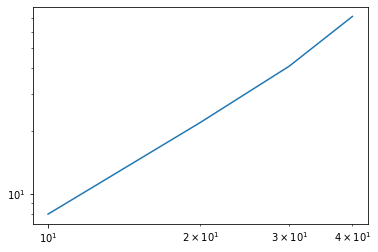

In [341]:
x=np.array([10,20,30,40])
y = np.array([199,213,232,262])
plt.xscale("log")
plt.yscale("log")
plt.plot(x,y-191)

In [281]:
%time f.iterate()





CPU times: user 226 ms, sys: 2.22 ms, total: 228 ms
Wall time: 227 ms


4.671635115499617e-06

In [47]:
marg2 = f.marginals()

In [60]:
list_obs

[(17, 0, 1), (17, 1, 2), (4, 0, 5)]

In [63]:
marg[18]

array([0., 1., 0., 0., 0., 0., 0.])

In [54]:
marg2.max()

1.0

In [49]:
marg2[:,0]

array([1.05331442e-01, 1.03258080e-01, 8.80581453e-02, 0.00000000e+00,
       4.48648467e-02, 0.00000000e+00, 1.17290901e-01, 1.06029962e-01,
       7.56343988e-03, 1.11619608e-01, 1.30028651e-01, 7.80647145e-03,
       1.03599220e-01, 1.01816643e-01, 0.00000000e+00, 1.89286381e-02,
       1.99627952e-04, 4.75530197e-02, 5.34503790e-02, 0.00000000e+00,
       3.79798185e-02, 1.12265473e-01, 9.51318049e-02, 0.00000000e+00,
       3.90957876e-02, 5.80995858e-02, 0.00000000e+00, 2.73140129e-02,
       1.11381498e-01, 4.20501819e-02, 1.46937923e-01, 9.53230869e-02,
       0.00000000e+00, 7.95775377e-02, 8.68142524e-02, 0.00000000e+00,
       1.41159081e-01, 6.03261868e-02, 9.37743528e-02, 9.35471800e-02,
       1.14849633e-01, 1.15754393e-01, 1.42421015e-01, 9.81064284e-02,
       9.22939492e-02, 7.50811142e-02, 4.79268467e-02, 1.31717242e-01,
       0.00000000e+00, 1.30183385e-01, 9.53408655e-02, 9.59115118e-02,
       4.59985365e-02, 1.32071672e-01, 9.97759457e-02, 5.80314248e-02,
      

# Print the marginals

In [32]:
#marginal at time 0
t1=0
M = np.zeros((T,N))
M_max = np.zeros((T,N))

for n in f.nodes:
    for t in range(T):
        M[t, n.index] = sib.marginal_t(n, t)[1]
        M_max[t, n.index] = max(sib.marginal_t(n, t)[0], sib.marginal_t(n, t)[1])
M_star = np.array(M > 0.5, dtype=float)

In [33]:
ov_i = (n_status[sim] == M_star).sum()
ov_tilde_i = M_max.sum()

In [34]:
ov_i, ov_tilde_i

(17153, 17412.469847553213)

In [36]:
M.sum(axis=1)

array([ 11.23145843,  14.7380238 ,  18.91428574,  23.88223583,
        29.78399116,  36.78417532,  45.07215715,  54.86390775,
        66.40313059,  79.96118617,  95.83517506, 114.34337113,
       135.81703359, 160.58751514, 188.96759422, 221.22618968,
       257.55619232, 298.0361941 , 342.58849265, 390.93784262])

In [502]:
ps = percentage_infected

In [514]:
def eta(t0):
    if t0 == 0:
        return 1 
    else:
        S = np.array([(1-lamb)**(t0-1-i)*eta(i) for i in range(1,t0) ])
        return ( ps*(1-lamb)**t0 + (1-ps)*((1-lamb)**(t0-1) + lamb*sum(S)) )**(d-1)

In [517]:
eta1

0.9732422709999999

In [523]:
eta(20)

1.7714835737129969e-06

# Analytic solution RRG

In [ ]:
def eta(t0):
    if t0 == 0:
        return 1 
    else:
        S = np.array([(1-lamb)**(t0-1-i)*eta(i) for i in range(1,t0) ])
        return ( ps*(1-lamb)**t0 + (1-ps)*((1-lamb)**(t0-1) + lamb*sum(S)) )**(d-1)

In [528]:
eta_tab = np.array([eta(t0) for t0 in range(T+1)])

In [531]:
1*(2>3)

0

In [524]:
m = np.full((T+2,T+2), ps/(T+2) )
for ti in range(T):
    for tj in range(-1,T+1):
        m[ti+1,tj+1] = ( (1-ps)/(T+2))*( ((1-lamb)**(ti-1-tj)*(ti-1>tj) + 1*(tj+2>ti))*eta_tab[ti] - ((1-lamb)**(ti-tj)*(ti>tj) + 1*(tj+1>ti))*eta_tab[ti+1] )

In [540]:
for tj in range(-1,T+1):
    m[-1,tj+1] = ( (1-ps)/(T+2))*((1-lamb)**(T-1-tj)*(T-1>tj) + 1*(tj+2>T))*eta_tab[T] 

In [544]:
np.sum(m-f.messages.values[0])

-1.6348794673192064e-17

In [527]:
len(range(-1,T+1))

15